In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from PyGaia.pygaia.astrometry import vectorastrometry as va
from astropy.coordinates import Angle
import matplotlib.pyplot as plt

In [2]:
def change_origin(obj, new):
    # Change origin from 'old' coordinate to 'new' (in cartesian) in kpc
    new_obj = SkyCoord(x=(obj.x - new.x), y=(obj.y - new.y), z=(obj.z - new.z), unit='kpc', representation_type='cartesian')
    return (new_obj)

In [3]:
def cart_to_radec(x, y, ra_c, dec_c, dist):
    """
    convert ra-dec to cartesian
    """
    old = SkyCoord(x=x, y=y, z=0, unit='kpc', representation_type='cartesian')
    new = new_obj = SkyCoord(x=0, y=0, z=dist, unit='kpc', representation_type='cartesian')
    new_c = change_origin(old, new)
    x1 = new_c.x.value
    y1 = new_c.y.value
    z1 = new_c.z.value
    r1 = np.array([x1, y1, z1])
    rot_mat = np.transpose(rotate(ra_c, dec_c))
    r = np.dot(rot_mat, r1)
    r2 = SkyCoord(x = r[0], y = r[1], z = r[2], unit = 'kpc', representation = 'cartesian', frame = 'icrs')
    r2.representation_type = 'spherical'
    return (r2)

In [4]:
def rotate(ra, dec):
   
    z90 = va.elementaryRotationMatrix("z", 90*u.deg)
    xdec = va.elementaryRotationMatrix("x", (90+dec)*u.deg)
    zlmst = va.elementaryRotationMatrix("z", (ra-90)*u.deg)
    rot_mat = np.dot(z90, np.dot(xdec, zlmst))
    return (rot_mat)

In [102]:
def true_to_app(om, w, i, a, ecc, E):
    """
    calculating projected seperation
    """
    A = a*(np.cos(w)*np.cos(om) - np.sin(w)*np.sin(om)*np.cos(i))
    B = a*(np.cos(w)*np.sin(om) + np.sin(w)*np.cos(om)*np.cos(i))
    F = a*(-np.sin(w)*np.cos(om) - np.cos(w)*np.sin(om)*np.cos(i))
    G = a*(-np.sin(w)*np.sin(om) + np.cos(w)*np.cos(om)*np.cos(i))
    
    X = np.cos(E) - ecc
    Y = np.sqrt(1-ecc**2)*np.sin(E)

    x_prj = A*X + F*Y
    y_prj = B*X + G*Y
    
    return ([x_prj, y_prj])

In [47]:
def iterate_E(E0, M, ecc):
    M0 = E0 - ecc*np.sin(E0)
    E1 = E0 + (M-M0)/(1-ecc*np.cos(E0))
    
    return ([E1, M0])

In [48]:
def compute_E(t, T, ecc, tp):
    """
    calculating eccentric anomaly E
    """
    M = (2*np.pi/tp)*(t-T) # Mean Anomaly M
    E0 = M + ecc*np.sin(M) + (ecc*2/M)*np.sin(2*M)
    E_M = [E0, M]
    
    for i in range(4):
        E = E_M[0]
        M = E_M[1]
        E_M = iterate_E(E, M, ecc)
    E = E_M[0]
    return (E)

In [8]:
def ra_dec_to_cart(r_c, r):
    sep = r_c.separation(r).value
    dist = np.sqrt(sep**2 + (r.distance.value)**2)
    ra = r_c.ra.value
    dec = r_c.dec.value
    r.representation_type = 'cartesian'
    r1 = np.array([r.x.value, r.y.value, r.z.value])
    rot_mat = rotate(ra, dec)
    r2 = np.dot(rot_mat, r1)
    old = SkyCoord(x=r2[0], y=r2[1], z=r2[2], unit='kpc', representation_type='cartesian')
    
    new_org = SkyCoord(x=0, y=0, z= -dist, unit='kpc', representation_type='cartesian')
    new = change_origin(old, new_org)
    
    return (new)

In [9]:
def true_app_radec(t, T, ecc, tp, ra_c, dec_c, x, y, dist, om, w, i, a):
    E = compute_E(t, T, ecc, tp)
    r = true_to_app(x, y, om, w, i, a, ecc, E)
    x1 = r[0]
    y1 = r[1]
    r1 = cart_to_radec(x1, y1, ra_c, dec_c, dist)
    return (r1)

In [205]:
def plotting(T, tp, ecc, w, om, i, a ):
    t = np.linspace(0.001, tp, 1000, endpoint = False)
    E_ = []
    for t1 in t:
        e = compute_E(t1, T, ecc, tp)
        E_.append(e) 
    E_ = np.array([E_])
    orb = [] 
    for k in E_:
        coord = true_to_app(om*u.degree,w*u.degree, i*u.degree, a, ecc, k)
        orb.append(coord)
    orb = orb[0]
    plt.plot(orb[0], orb[1], '.r-')

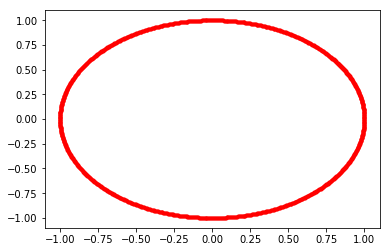

In [206]:
plotting(0, 1000, 0, 90, 90, 0, 1)

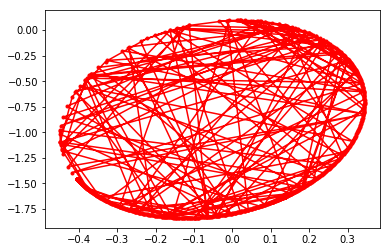

In [207]:
plotting(0, 1000, 0.9, 30, 60, 30, 1)

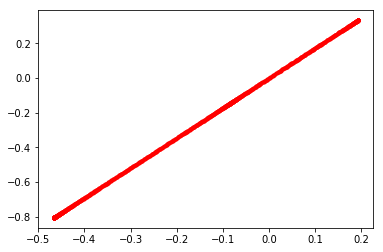

In [222]:
plotting(0, 1000, 0.8, 70, 60, 90, 1)

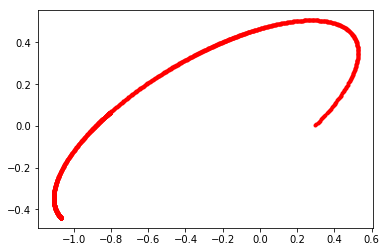

In [223]:
plotting(0, 1000, 0.5, 60, 30, 110, 1)